In [1]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load CIFAR-100 dataset from local files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Function to load data from multiple batches
def load_data_from_batches(batch_files):
    images = []
    labels = np.array([])
    for file in batch_files:
        batch = unpickle(file)
        #print(batch)
        batch_images = batch[b'data']
        batch_images = batch_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
        images.append(batch_images)
        labels = np.append(labels, batch[b'labels'])
    return np.vstack(images), labels.astype(np.int64)

In [3]:
data_batch_files = [f'cifar-10-python/cifar-10-batches-py/{batch}' for batch in ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']]

x_train, y_train = load_data_from_batches(data_batch_files)

with open('cifar-10-python/cifar-10-batches-py/test_batch', 'rb') as file:
    test_batch = pickle.load(file, encoding='bytes')
    x_test = test_batch[b'data'].reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch[b'labels'])

with open('cifar-10-python/cifar-10-batches-py/batches.meta', 'rb') as file:
    batch = pickle.load(file, encoding='bytes')
    label_names = batch[b'label_names']

# Converting to Tensors

In [4]:
# Convert the NumPy array to a PyTorch tensor
x_train = torch.tensor(x_train, dtype=torch.uint8)

# Permute the dimensions to change the shape to (10000, 3, 32, 32)
x_train = x_train.permute(0, 3, 1, 2)

# Convert the NumPy array to a PyTorch tensor
x_test = torch.tensor(x_test, dtype=torch.uint8)

# Permute the dimensions to change the shape to (10000, 3, 32, 32)
x_test = x_test.permute(0, 3, 1, 2)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

In [5]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Train unique classes: {np.unique(y_train)}\nTest unique classes: {np.unique(y_test)}")
print(f"Corresponding labels: {label_names}")

x_train shape: torch.Size([45000, 3, 32, 32])
y_train shape: (45000,)
x_val shape: torch.Size([5000, 3, 32, 32])
y_val shape: (5000,)
x_test shape: torch.Size([10000, 3, 32, 32])
y_test shape: (10000,)
Train unique classes: [0 1 2 3 4 5 6 7 8 9]
Test unique classes: [0 1 2 3 4 5 6 7 8 9]
Corresponding labels: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


Label:  b'automobile' (1)


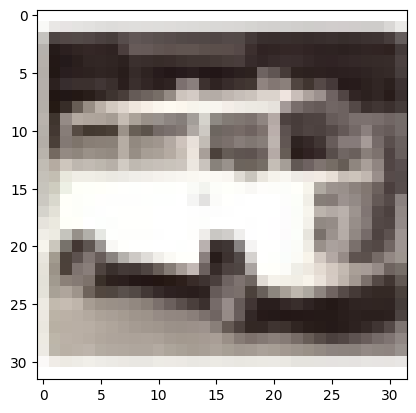

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', label_names[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

index = 1
show_example(x_train[index], y_train[index])

 # Data Augmentation

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [8]:
# Example augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),
    A.RandomBrightnessContrast (p=0.5),
    A.CLAHE(clip_limit=1.0, tile_grid_size=(1, 1), always_apply=False, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=1),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, p=0.5),
    A.RandomCrop(width=32, height=32),
    ToTensorV2(),
])

/tmp/ipykernel_146742/4037322209.py:4: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma(gamma_limit=(80, 120), eps=None, always_apply=False, p=0.5),


In [37]:
# Convert the images tensor to a NumPy array
images_np = x_train.permute(0, 2, 3, 1).numpy()

augmented_images = []
augmented_labels = []
number_of_augmented_images = 2

# Apply augmentations and collect augmented images and labels
for idx, (img, label) in enumerate(zip(images_np, y_train)):
    if idx < np.inf:
        print(f"index: {idx}")
        for _ in range(number_of_augmented_images):  # Create 3 augmented versions of each image
            augmented = transform(image=img)
            augmented_images.append(augmented['image'])
            augmented_labels.append(label)

index: 0
index: 1
index: 2
index: 3
index: 4
index: 5
index: 6
index: 7
index: 8
index: 9


In [38]:
# Convert the lists of augmented images and labels to tensors
augmented_images_tensor = torch.stack(augmented_images)

# Combine the original and augmented datasets
combined_images_tensor = torch.cat((x_train, augmented_images_tensor), dim=0)
combined_labels = np.append(y_train, augmented_labels)

print(combined_images_tensor.shape)  # Should output torch.Size([40000, 3, 32, 32])
print(combined_labels.shape)  # Should output torch.Size([40000])

torch.Size([45020, 3, 32, 32])
(45020,)


# Drawing Augmented Images

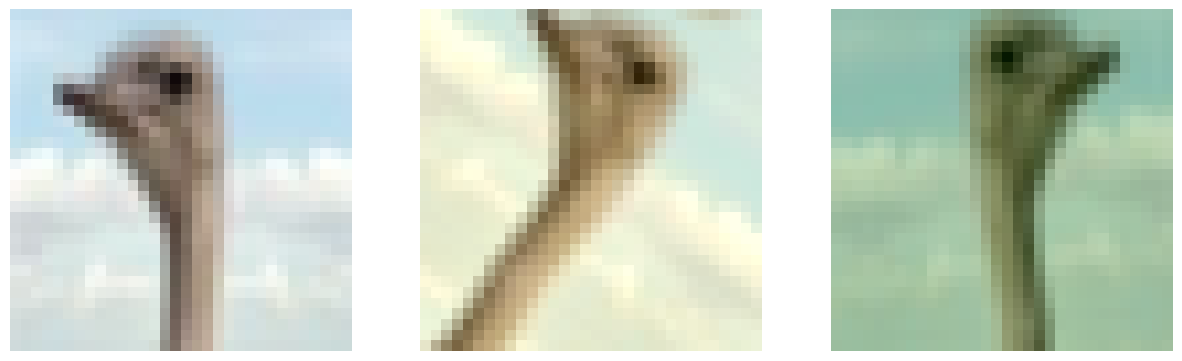

In [39]:
original_image_index = 7

indices = [original_image_index]

base_index = x_train.shape[0] + original_image_index * number_of_augmented_images
for i in range(number_of_augmented_images):
    indices.append(base_index + i)

# Extract the images based on the provided indices
selected_images = combined_images_tensor[indices]

# Plot the images side by side
fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
for ax, img in zip(axes, selected_images):
    # Permute the image tensor from (3, 32, 32) to (32, 32, 3) for plotting
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

plt.show()

## Smaller training set

In [16]:
num_classes = 10
images_per_class = 100

# List to store indices of the selected images
selected_indices = []

# Loop over each class
for class_idx in range(num_classes):
    # Get indices of all images of the current class
    class_indices = (combined_labels == class_idx).nonzero()[0]
    # Select the first 100 indices (or all if less than 100 are available)
    selected_indices.extend(class_indices[:images_per_class].tolist())

# Create tensors for the selected images and labels
selected_images_tensor = combined_images_tensor[selected_indices]
selected_labels = combined_labels[selected_indices]

print(selected_images_tensor.shape)  # Should output torch.Size([1000, 3, 32, 32])
print(selected_labels.shape)

torch.Size([1000, 3, 32, 32])
(1000,)


# Train & Validation Split

In [17]:
random_seed = 42
torch.manual_seed(random_seed);

In [18]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)  # Assuming y_data are labels and should be long integers

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Change dimensions to (3, 32, 32) if necessary
        y = self.y_data[idx]
        return x, y

# Original training set
#train_ds = CustomDataset(x_train, y_train) 

# Training + Augmented
train_ds = CustomDataset(combined_images_tensor, combined_labels)

# Small subset of training set
#train_ds = CustomDataset(selected_images_tensor, selected_labels)

# Validation set is the same for all
val_ds = CustomDataset(x_val, y_val)

print(f"train_ds shape: {train_ds.x_data.shape}")
print(f"val_ds shape: {val_ds.x_data.shape}")

train_ds shape: torch.Size([45030, 3, 32, 32])
val_ds shape: torch.Size([5000, 3, 32, 32])


/tmp/ipykernel_146742/1471021754.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_data = torch.tensor(x_data, dtype=torch.float32)


In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        images = torch.tensor(images, dtype=torch.int32)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

/tmp/ipykernel_146742/3601700830.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.int32)


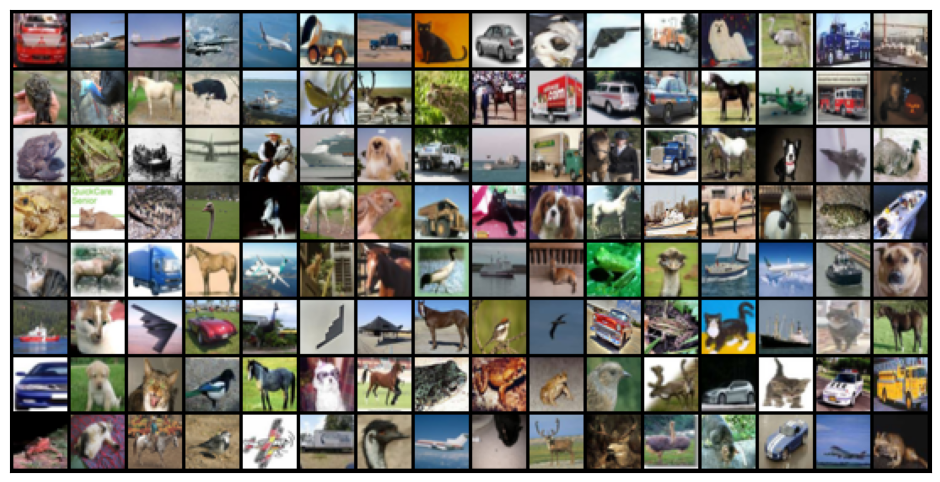

In [22]:
show_batch(train_dl)

# CNN

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [26]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [27]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.1021,  0.0628, -0.0003, -0.0586, -0.1344,  0.0826,  0.0206,  0.0833,
         0.0624,  0.0464], grad_fn=<SelectBackward0>)


In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cpu')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
model = to_device(Cifar10CnnModel(), device)

In [33]:
evaluate(model, val_dl)

{'val_loss': 2.3064494132995605, 'val_acc': 0.10097656399011612}

In [34]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [35]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

KeyboardInterrupt: 

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing Performance

In [ ]:
test_dataset = CustomDataset(x_test, y_test)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return label_names[preds[0].item()]

In [ ]:
img, label = test_dataset[4]
prediction = predict_image(img, model)
img = torch.tensor(img, dtype=torch.int32)
plt.imshow(img.permute(1, 2, 0))
print('Label:', label_names[label], ', Predicted:', prediction)